# Secure Water Treatment (SWaT)

- Source and description: https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

In [1]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from config import data_raw_folder, data_processed_folder

from timeeval import Datasets, DatasetManager
from timeeval.datasets import DatasetAnalyzer, DatasetRecord

try:
    from openpyxl import Workbook
except ImportError:
    import sys
    !conda install --yes --prefix {sys.prefix} openpyxl
    from openpyxl import Workbook

In [2]:
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
source_folder = Path(data_raw_folder) / "SWaT"
target_folder = Path(data_processed_folder)

path_mapping = {
    "SWaT-A1&A2": (
        source_folder / "SWaT.A1&A2_Dec 2015" / "Physical" / "SWaT_Dataset_Attack_v0.xlsx",  # test
        source_folder / "SWaT.A1&A2_Dec 2015" / "Physical" / "SWaT_Dataset_Normal_v1.xlsx",  # train
    ),
    # "SWaT-A3": "",  # not relevant
    # "SWaT-A4": "SWaT.A4&A5_Jul 2019",  # use A5
    "SWaT-A5": source_folder / "SWaT.A4&A5_Jul 2019" / "SWaT_dataset_Jul 19 v2.xlsx",  # only test = unsupervised
    "SWaT-A6": source_folder / "SWaT.A6_Dec 2019" / "csv" / "Dec2019.xlsx",  # only test = unsupervised
    # "SWaT-A7": "",  # not relevant
    # "SWaT-A8": "",  # note relevant
    
}

# define anomalies
anomalies_A5 = {
    "Attack1": {
        "description": "Spoof value of FIT401 from 0.8 to 0.5 to stop de-chlorination by switching off UV401",
        "targets": ["FIT 401"],
        "begin": "2019-07-20 15:08:46+08:00",
        "end": "2019-07-20 15:10:31+08:00"
    },
    "Attack2": {
        "description": " Spoof value of LIT301 from 835 to 1024 to eventually lead to underflow in T301",
        "targets": ["LIT 301"],
        "begin": "2019-07-20 15:15:00+08:00",
        "end": "2019-07-20 15:19:32+08:00"
    },
    "Attack3": {
        "description": "Switch P601 from OFF to ON to increase water in raw water tank",
        "targets": ["P601 Status"],
        "begin": "2019-07-20 15:26:57+08:00",
        "end": "2019-07-20 15:30:48+08:00"
    },
    "Attack4": {
        "description": "Switch from CLOSE to OPEN (MV201) and OFF to ON (P101) to overflow tank T301",
        "targets": ["MV201", "P101 Status"],
        "begin": "2019-07-20 15:38:50+08:00",
        "end": "2019-07-20 15:46:20+08:00"
    },
    "Attack5": {
        "description": "Switch MV501 from OPEN to CLOSE to drain water from RO",
        "targets": ["MV 501"],
        "begin": "2019-07-20 15:54:00+08:00",
        "end": "2019-07-20 15:56:00+08:00"
    },
    "Attack6": {
        "description": "Switch P301 from ON to OFF to halt stage 3 (UF process)",
        "targets": ["P301 Status"],
        "begin": "2019-07-20 16:02:56+08:00",
        "end": "2019-07-20 16:16:18+08:00"
    },
}

for a in anomalies_A5:
    for dt_key in ["begin", "end"]:
        dt = anomalies_A5[a][dt_key]
        # convert times to UTZ-datetimes
        dt = pd.to_datetime(dt).astimezone(tz="UTC")
        
        # fix anomaly labels (timestamps)
        dt = dt - pd.Timedelta(2, unit="m") + pd.Timedelta(14, unit="s")
        anomalies_A5[a][dt_key] = dt

    if a == "Attack1":
        anomalies_A5[a]["begin"] -= pd.Timedelta(2, unit="s")
        anomalies_A5[a]["end"] -= pd.Timedelta(1, unit="s")
    elif a == "Attack2":
        anomalies_A5[a]["begin"] += pd.Timedelta(5, unit="s")
    elif a == "Attack4":
        anomalies_A5[a]["end"] += pd.Timedelta(30, unit="s")
    elif a == "Attack5":
        anomalies_A5[a]["begin"] += pd.Timedelta(3, unit="s")
        anomalies_A5[a]["end"] += pd.Timedelta(40, unit="s")
    elif a == "Attack6":
        anomalies_A5[a]["begin"] -= pd.Timedelta(5, unit="s")
        anomalies_A5[a]["end"] += pd.Timedelta(35, unit="s")

anomalies_A6 = {
    "C2Com&Attack5": {
        "description": "Infiltrate SCADA WS with second payload from C2, and disrupt sensors cycle 1",
        "begin": "12:30",
        "end": "12:33"
    },
    "Attack6": {
        "description": "Disrupt sensors cycle 2",
        "begin": "12:43",
        "end": "12:46"
    },
    "Attack7": {
        "description": "Disrupt sensors cycle 3",
        "begin": "12:56",
        "end": "12:59"
    },
    "Attack8": {
        "description": "Disrupt sensors cycle 4",
        "begin": "13:09",
        "end": "13:12"
    },
    "Attack9": {
        "description": "Disrupt sensors cycle 5",
        "begin": "13:22",
        "end": "13:25"
    }
}

date = "2019-12-06"
tz = "Asia/Hong_Kong"
for a in anomalies_A6:
    for dt_key in ["begin", "end"]:
        # convert times to datetimes
        dt = anomalies_A6[a][dt_key]
        dt = pd.to_datetime(f"{date} {dt}:00").tz_localize(tz=tz)
        anomalies_A6[a][dt_key] = dt

print(f"Looking for source datasets in {Path(source_folder).absolute()} and\nsaving processed datasets in {Path(target_folder).absolute()}")

Looking for source datasets in /home/projects/akita/data/benchmark-data/data-raw/SWaT and
saving processed datasets in /home/projects/akita/data/benchmark-data/data-processed


In [4]:
# shared by all datasets
dataset_collection_name = "SWaT"
dataset_type = "real"
input_type = "multivariate"
datetime_index = True
split_at = None

# create target subfolder
dataset_subfolder = Path(input_type) / dataset_collection_name
target_subfolder = target_folder / dataset_subfolder
target_subfolder.mkdir(parents=True, exist_ok=True)
print(f"Created directories {target_subfolder}")

dm = DatasetManager(target_folder)

Created directories /home/projects/akita/data/benchmark-data/data-processed/multivariate/SWaT


In [5]:
def add_anomalies(df: pd.DataFrame, anomalies: dict) -> pd.DataFrame:
    df = df.set_index("timestamp")
    df["is_anomaly"] = 0
    for a in anomalies:
        begin = anomalies[a]["begin"]
        end = anomalies[a]["end"]
        df.loc[begin:end, "is_anomaly"] = 1
    df = df.reset_index()
    return df

def prepare_dataset_A1_A2(dataset_path: Path) -> pd.DataFrame:
    df = pd.read_excel(
        dataset_path,
        sheet_name=0,
        skiprows=1,
        header=0,
        index_col=None,
        parse_dates=[0]
    )
    df = df.rename(columns={" Timestamp": "timestamp"})
    df["is_anomaly"] = 0
    df.loc[df["Normal/Attack"] == "Attack", "is_anomaly"] = 1
    df = df.drop(columns=["Normal/Attack"])
    return df

def prepare_dataset_A5(dataset_path: Path) -> pd.DataFrame:
    df = pd.read_excel(
        dataset_path,
        sheet_name=0,
        skiprows=1,
        header=[0, 1],
        index_col=None,
        parse_dates=[0]
    )
    # align header
    df.columns = list(df.columns.get_level_values(1)[0:1]) + list(df.columns.get_level_values(0)[1:])

    # round timestamps to have equi-distant steps (= seconds)
    df["timestamp"] = df["timestamp"].map(lambda dt: dt.floor(freq="S"))

    # make actuator status numeric
    df = df.replace("Inactive", 0)
    df = df.replace("Active", 1)

    # add anomaly labels
    df = add_anomalies(df, anomalies_A5)
    return df

def prepare_dataset_A6(dataset_path: Path) -> pd.DataFrame:
    df = pd.read_excel(
        dataset_path,
        sheet_name=0,
        skiprows=9,
        header=0,
        index_col=None,
        parse_dates=[0]
    )

    # localize and convert timestamp
    s = df["t_stamp"]
    s = s.map(lambda dt: dt.tz_localize(tz="Asia/Hong_Kong"))
    df.insert(0, "timestamp", s)
    df.drop(columns=["t_stamp"], inplace=True)

    # make actuator status numeric
    df = df.replace("Inactive", 0)
    df = df.replace("Active", 1)

    # add anomaly labels
    df = add_anomalies(df, anomalies_A6)
    return df

## A1 and A2

In [6]:
dataset_name = "SWaT-A1&A2"
train_type = "semi-supervised"
train_is_normal = True

print(f"-> Processing dataset {dataset_name}")

test_filename = f"{dataset_name}.test.csv"
train_filename = f"{dataset_name}.train.csv"
test_path = dataset_subfolder / test_filename
train_path = dataset_subfolder / train_filename
target_test_filepath = target_subfolder / test_filename
target_train_filepath = target_subfolder / train_filename
target_meta_filepath = target_test_filepath.parent / f"{dataset_name}.{Datasets.METADATA_FILENAME_SUFFIX}"

# prepare test dataset
source_paths = path_mapping[dataset_name]
df_test = prepare_dataset_A1_A2(source_paths[0])
df_test.to_csv(target_test_filepath, index=False)
print("  written test dataset")

da = DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=False, df=df_test, ignore_stationarity=True)
da.save_to_json(target_meta_filepath, overwrite=True)
meta = da.metadata
del da
del df_test
print("  analyzed test dataset")

# prepare train dataset
df_train = prepare_dataset_A1_A2(source_paths[1])
df_train.to_csv(target_train_filepath, index=False)
print(f"  written training dataset")

DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=True, df=df_train, ignore_stationarity=True)\
    .save_to_json(target_meta_filepath, overwrite=False)
del df_train
print(f"  analyzed training dataset")

dm.add_dataset(DatasetRecord(
      collection_name=dataset_collection_name,
      dataset_name=dataset_name,
      train_path=train_path,
      test_path=test_path,
      dataset_type=dataset_type,
      datetime_index=datetime_index,
      split_at=split_at,
      train_type=train_type,
      train_is_normal=train_is_normal,
      input_type=input_type,
      length=meta.length,
      dimensions=meta.dimensions,
      contamination=meta.contamination,
      num_anomalies=meta.num_anomalies,
      min_anomaly_length=meta.anomaly_length.min,
      median_anomaly_length=meta.anomaly_length.median,
      max_anomaly_length=meta.anomaly_length.max,
      mean=meta.mean,
      stddev=meta.stddev,
      trend=meta.trend,
      stationarity=meta.get_stationarity_name(),
      period_size=np.nan
))
print(f"... processed dataset {dataset_name}")

-> Processing dataset SWaT-A1&A2


/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  written test dataset
  analyzed test dataset


/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  written training dataset
  analyzed training dataset
... processed dataset SWaT-A1&A2


## A5

In [8]:
dataset_name = "SWaT-A5"
train_type = "unsupervised"
train_is_normal = False

print(f"-> Processing dataset {dataset_name}")

test_filename = f"{dataset_name}.test.csv"
test_path = dataset_subfolder / test_filename
target_test_filepath = target_subfolder / test_filename
target_meta_filepath = target_test_filepath.parent / f"{dataset_name}.{Datasets.METADATA_FILENAME_SUFFIX}"

# prepare test dataset
source_path = path_mapping[dataset_name]
df_test = prepare_dataset_A5(source_path)
df_test.to_csv(target_test_filepath, index=False)
print("  written test dataset")

da = DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=False, df=df_test)
da.save_to_json(target_meta_filepath, overwrite=True)
meta = da.metadata
del da
del df_test
print("  analyzed test dataset")

dm.add_dataset(DatasetRecord(
      collection_name=dataset_collection_name,
      dataset_name=dataset_name,
      train_path=None,
      test_path=test_path,
      dataset_type=dataset_type,
      datetime_index=datetime_index,
      split_at=split_at,
      train_type=train_type,
      train_is_normal=train_is_normal,
      input_type=input_type,
      length=meta.length,
      dimensions=meta.dimensions,
      contamination=meta.contamination,
      num_anomalies=meta.num_anomalies,
      min_anomaly_length=meta.anomaly_length.min,
      median_anomaly_length=meta.anomaly_length.median,
      max_anomaly_length=meta.anomaly_length.max,
      mean=meta.mean,
      stddev=meta.stddev,
      trend=meta.trend,
      stationarity=meta.get_stationarity_name(),
      period_size=np.nan
))
print(f"... processed dataset {dataset_name}")

-> Processing dataset SWaT-A5
  written test dataset


[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for P102 Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for LS 201 encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for LS 202 encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for LSL 203 encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for LSLL 203 encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for P2_STATE encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for P201 Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A5') (test)] KPSS trend stationarity test for P202 Status encountered an error: 

  analyzed test dataset
... processed dataset SWaT-A5


## A6

In [9]:
dataset_name = "SWaT-A6"
train_type = "unsupervised"
train_is_normal = False

print(f"-> Processing dataset {dataset_name}")

test_filename = f"{dataset_name}.test.csv"
test_path = dataset_subfolder / test_filename
target_test_filepath = target_subfolder / test_filename
target_meta_filepath = target_test_filepath.parent / f"{dataset_name}.{Datasets.METADATA_FILENAME_SUFFIX}"

# prepare test dataset
source_path = path_mapping[dataset_name]
df_test = prepare_dataset_A6(source_path)
df_test.to_csv(target_test_filepath, index=False)
print("  written test dataset")

da = DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=False, df=df_test)
da.save_to_json(target_meta_filepath, overwrite=True)
meta = da.metadata
del da
del df_test
print("  analyzed test dataset")

dm.add_dataset(DatasetRecord(
      collection_name=dataset_collection_name,
      dataset_name=dataset_name,
      train_path=None,
      test_path=test_path,
      dataset_type=dataset_type,
      datetime_index=datetime_index,
      split_at=split_at,
      train_type=train_type,
      train_is_normal=train_is_normal,
      input_type=input_type,
      length=meta.length,
      dimensions=meta.dimensions,
      contamination=meta.contamination,
      num_anomalies=meta.num_anomalies,
      min_anomaly_length=meta.anomaly_length.min,
      median_anomaly_length=meta.anomaly_length.median,
      max_anomaly_length=meta.anomaly_length.max,
      mean=meta.mean,
      stddev=meta.stddev,
      trend=meta.trend,
      stationarity=meta.get_stationarity_name(),
      period_size=np.nan
))
print(f"... processed dataset {dataset_name}")

-> Processing dataset SWaT-A6
  written test dataset


[('SWaT', 'SWaT-A6') (test)] ADF stationarity test for P101.Status encountered an error: exog contains inf or nans
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P101.Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P102.Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P2_STATE encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P202.Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P204.Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P205.Status encountered an error: cannot convert float NaN to integer
[('SWaT', 'SWaT-A6') (test)] KPSS trend stationarity test for P206.Status encountered an error: 

  analyzed test dataset
... processed dataset SWaT-A6


In [11]:
dm.save()

In [13]:
dm.refresh()
dm.df().loc[(slice(dataset_collection_name,dataset_collection_name), slice(None))]

train_path  \
collection_name dataset_name                                           
SWaT            SWaT-A1&A2    multivariate/SWaT/SWaT-A1&A2.train.csv   
                SWaT-A5                                          NaN   
                SWaT-A6                                          NaN   

                                                          test_path  \
collection_name dataset_name                                          
SWaT            SWaT-A1&A2    multivariate/SWaT/SWaT-A1&A2.test.csv   
                SWaT-A5          multivariate/SWaT/SWaT-A5.test.csv   
                SWaT-A6          multivariate/SWaT/SWaT-A6.test.csv   

                             dataset_type  datetime_index  split_at  \
collection_name dataset_name                                          
SWaT            SWaT-A1&A2           real            True       NaN   
                SWaT-A5              real            True       NaN   
                SWaT-A6              real            True       NaN   

                                   train_type  train_is_normal    input_type  \
collection_name dataset_name                                                   
SWaT            SWaT-A1&A2    semi-supervised             True  multivariate   
                SWaT-A5          unsupervised            False  multivariate   
                SWaT-A6          unsupervised            False  multivariate   

                              length  dimensions  contamination  \
collection_name dataset_name                                      
SWaT            SWaT-A1&A2    449919          51       0.121320   
                SWaT-A5        14996          77       0.139304   
                SWaT-A6        13201          81       0.068555   

                              num_anomalies  min_anomaly_length  \
collection_name dataset_name                                      
SWaT            SWaT-A1&A2               35                 101   
                SWaT-A5                   6                 107   
                SWaT-A6                   5                 181   

                              median_anomaly_length  max_anomaly_length  \
collection_name dataset_name                                              
SWaT            SWaT-A1&A2                      444               35900   
                SWaT-A5                         250                 843   
                SWaT-A6                         181                 181   

                                   mean     stddev        trend  \
collection_name dataset_name                                      
SWaT            SWaT-A1&A2    80.458572  12.783598  kubic trend   
                SWaT-A5       64.099889   5.353307  kubic trend   
                SWaT-A6       48.592063   4.026858  kubic trend   

                                stationarity  period_size  
collection_name dataset_name                               
SWaT            SWaT-A1&A2    not_stationary          NaN  
                SWaT-A5       not_stationary          NaN  
                SWaT-A6       not_stationary          NaN

## Exploration

### A1 and A2

In [14]:
df = pd.read_excel(
    source_folder / "SWaT.A1&A2_Dec 2015" / "Physical" / "SWaT_Dataset_Attack_v0.xlsx",
    sheet_name=0,
    skiprows=1,
    header=0,
    index_col=None,
    parse_dates=[0]
)
df["is_anomaly"] = 0
df.loc[df["Normal/Attack"] == "Attack", "is_anomaly"] = 1
df = df.drop(columns=["Normal/Attack"])
df

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,is_anomaly
0,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,0
1,2015-12-28 10:00:01,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,0
2,2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,0
3,2015-12-28 10:00:03,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,0
4,2015-12-28 10:00:04,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2016-02-01 14:59:55,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,0
449915,2016-02-01 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,0
449916,2016-02-01 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,0
449917,2016-02-01 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,0


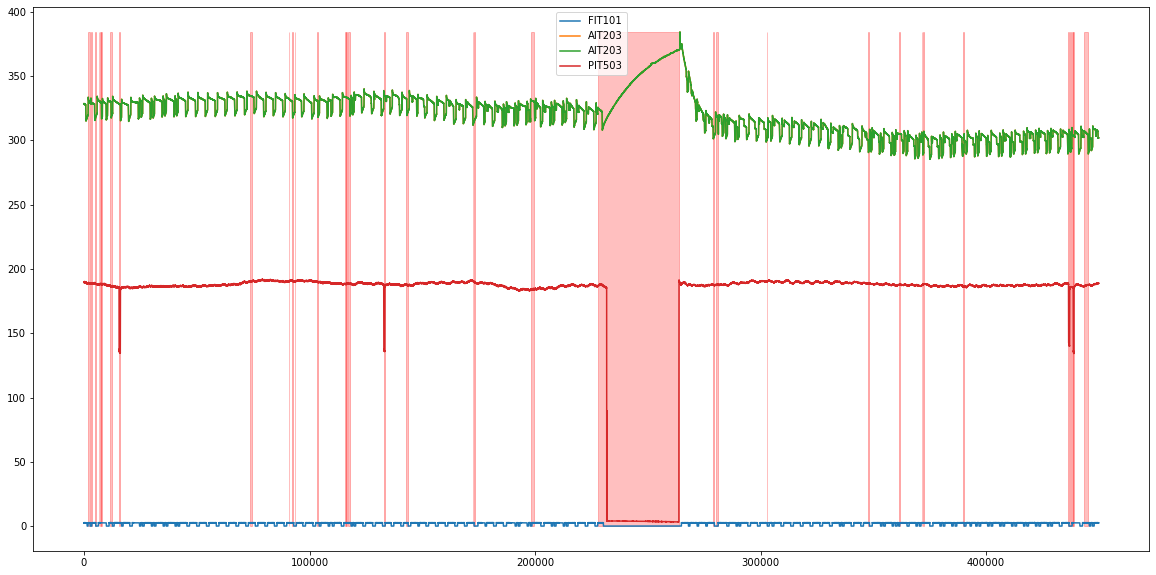

In [15]:
df_tmp = df[["FIT101", "AIT203", "AIT203", "PIT503", "is_anomaly"]]
df_tmp.iloc[:, :-1].plot()
s = df_tmp["is_anomaly"].diff()
for begin, end in zip(s[s == -1].index, s[s == 1].index):
    plt.gca().add_patch(matplotlib.patches.Rectangle((begin, 0), end - begin, df_tmp.max().max(), color="red", alpha=0.25))
plt.show()

In [16]:
df = pd.read_excel(
    source_folder / "SWaT.A1&A2_Dec 2015" / "Physical" / "SWaT_Dataset_Normal_v1.xlsx",
    sheet_name=0,
    skiprows=1,
    header=0,
    index_col=None,
    parse_dates=[0]
)
df["is_anomaly"] = 0
df.loc[df["Normal/Attack"] == "Attack", "is_anomaly"] = 1
df = df.drop(columns=["Normal/Attack"])
df

/home/sebastian.schmidl/.conda/envs/timeeval/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,is_anomaly
0,2015-12-22 16:30:00,0.000000,124.3135,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,0
1,2015-12-22 16:30:01,0.000000,124.3920,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,0
2,2015-12-22 16:30:02,0.000000,124.4705,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,0
3,2015-12-22 16:30:03,0.000000,124.6668,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,0
4,2015-12-22 16:30:04,0.000000,124.5098,1,1,1,251.9226,8.313446,312.7916,0.000000,...,1,1,9.100231,0.000000,3.3485,0.000256,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494995,2015-12-28 09:59:55,2.460366,523.0430,2,2,1,262.0161,8.396437,328.5055,2.442316,...,2,1,250.817100,1.778105,189.8552,0.000128,1,1,1,0
494996,2015-12-28 09:59:56,2.448836,522.9645,2,2,1,262.0161,8.396437,328.5055,2.442316,...,2,1,250.817100,1.778105,189.5027,0.000128,1,1,1,0
494997,2015-12-28 09:59:57,2.434744,522.8860,2,2,1,262.0161,8.396437,328.6337,2.444879,...,2,1,250.817100,1.778105,189.5027,0.000128,1,1,1,0
494998,2015-12-28 09:59:58,2.428338,522.9252,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.817100,1.649953,189.5027,0.000128,1,1,1,0


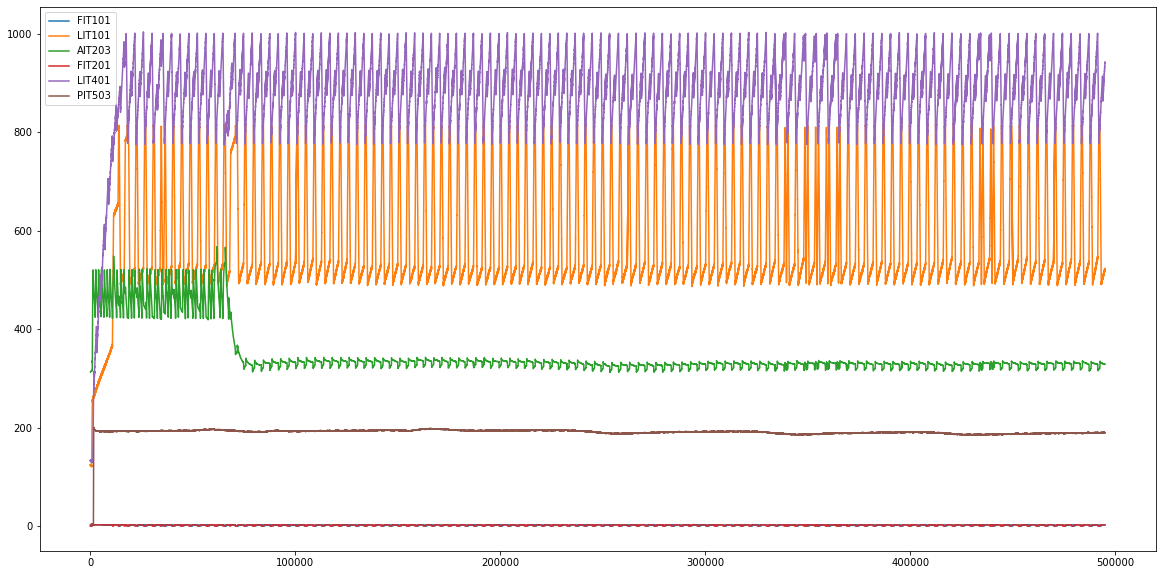

In [17]:
df_tmp = df[["FIT101", "LIT101", "AIT203", "FIT201", "LIT401", "PIT503", "is_anomaly"]]
df_tmp.iloc[:, :-1].plot()
s = df_tmp["is_anomaly"].diff()
for begin, end in zip(s[s == -1].index, s[s == 1].index):
    plt.gca().add_patch(matplotlib.patches.Rectangle((begin, 0), end - begin, df_tmp.max().max(), color="red", alpha=0.25))
plt.show()

### A5

In [18]:
df = pd.read_excel(
    source_folder / "SWaT.A4&A5_Jul 2019" / "SWaT_dataset_Jul 19 v2.xlsx",
    sheet_name=0,
    skiprows=1,
    header=[0, 1],
    index_col=None,
    parse_dates=[0]
)

# align header
df.columns = list(df.columns.get_level_values(1)[0:1]) + list(df.columns.get_level_values(0)[1:])

# round timestamps to have equi-distant timesteps (= seconds)
df["timestamp"] = df["timestamp"].map(lambda dt: dt.floor(freq="S"))

df = df.replace("Inactive", 0)
df = df.replace("Active", 1)

df

,timestamp,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,...,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20 04:30:00+00:00,0.000000,729.865800,1,3,2,1,142.527557,9.293002,198.077423,...,1,1,0,0,0,1,2,1,1,1
1,2019-07-20 04:30:01+00:00,0.000000,729.434000,1,3,2,1,142.527557,9.293002,198.385025,...,1,1,0,0,0,1,2,1,1,1
2,2019-07-20 04:30:02+00:00,0.000000,729.120000,1,3,2,1,142.527557,9.293002,198.436300,...,1,1,0,0,0,1,2,1,1,1
3,2019-07-20 04:30:03+00:00,0.000000,728.688200,1,3,2,1,142.527557,9.289157,198.667000,...,1,1,0,0,0,1,2,1,1,1
4,2019-07-20 04:30:04+00:00,0.000000,727.706900,1,3,2,1,142.527557,9.289157,198.897720,...,1,1,0,0,0,1,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,2019-07-20 08:39:55+00:00,4.200429,491.169769,2,2,2,1,131.408615,9.319918,257.703156,...,1,1,0,0,0,1,2,1,1,1
14992,2019-07-20 08:39:56+00:00,4.253915,491.405273,2,2,2,1,131.408615,9.317354,257.703156,...,1,1,0,0,0,1,2,1,1,1
14993,2019-07-20 08:39:57+00:00,4.303558,492.308100,2,2,2,1,131.408615,9.317354,257.703156,...,1,1,0,0,0,1,2,1,1,1
14994,2019-07-20 08:39:58+00:00,4.323736,492.465100,2,2,2,1,131.408615,9.316713,257.703156,...,1,1,0,0,0,1,2,1,1,1


In [19]:
# define anomalies
anomalies = {
    "Attack1": {
        "description": "Spoof value of FIT401 from 0.8 to 0.5 to stop de-chlorination by switching off UV401",
        "targets": ["FIT 401"],
        "begin": "2019-07-20 15:08:46+08:00",
        "end": "2019-07-20 15:10:31+08:00"
    },
    "Attack2": {
        "description": " Spoof value of LIT301 from 835 to 1024 to eventually lead to underflow in T301",
        "targets": ["LIT 301"],
        "begin": "2019-07-20 15:15:00+08:00",
        "end": "2019-07-20 15:19:32+08:00"
    },
    "Attack3": {
        "description": "Switch P601 from OFF to ON to increase water in raw water tank",
        "targets": ["P601 Status"],
        "begin": "2019-07-20 15:26:57+08:00",
        "end": "2019-07-20 15:30:48+08:00"
    },
    "Attack4": {
        "description": "Switch from CLOSE to OPEN (MV201) and OFF to ON (P101) to overflow tank T301",
        "targets": ["MV201", "P101 Status"],
        "begin": "2019-07-20 15:38:50+08:00",
        "end": "2019-07-20 15:46:20+08:00"
    },
    "Attack5": {
        "description": "Switch MV501 from OPEN to CLOSE to drain water from RO",
        "targets": ["MV 501"],
        "begin": "2019-07-20 15:54:00+08:00",
        "end": "2019-07-20 15:56:00+08:00"
    },
    "Attack6": {
        "description": "Switch P301 from ON to OFF to halt stage 3 (UF process)",
        "targets": ["P301 Status"],
        "begin": "2019-07-20 16:02:56+08:00",
        "end": "2019-07-20 16:16:18+08:00"
    },
}

for a in anomalies:
    for dt_key in ["begin", "end"]:
        # convert times to UTZ-datetimes
        dt = pd.to_datetime(anomalies[a][dt_key]).astimezone(tz="UTC")
        
        # fix anomaly labels (timestamps)
        dt = dt - pd.Timedelta(2, unit="m") + pd.Timedelta(14, unit="s")
        anomalies[a][dt_key] = dt
    if a == "Attack1":
        anomalies[a]["begin"] -= pd.Timedelta(2, unit="s")
        anomalies[a]["end"] -= pd.Timedelta(1, unit="s")
    elif a == "Attack2":
        anomalies[a]["begin"] += pd.Timedelta(5, unit="s")
    elif a == "Attack4":
        anomalies[a]["end"] += pd.Timedelta(30, unit="s")
    elif a == "Attack5":
        anomalies[a]["begin"] += pd.Timedelta(3, unit="s")
        anomalies[a]["end"] += pd.Timedelta(40, unit="s")
    elif a == "Attack6":
        anomalies[a]["begin"] -= pd.Timedelta(5, unit="s")
        anomalies[a]["end"] += pd.Timedelta(35, unit="s")

In [20]:
df = df.set_index("timestamp")

df["is_anomaly"] = 0

for a in anomalies:
    begin = anomalies[a]["begin"]
    end = anomalies[a]["end"]
    df.loc[begin:end, "is_anomaly"] = 1
df = df.reset_index()
df

,timestamp,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,...,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status,is_anomaly
0,2019-07-20 04:30:00+00:00,0.000000,729.865800,1,3,2,1,142.527557,9.293002,198.077423,...,1,0,0,0,1,2,1,1,1,0
1,2019-07-20 04:30:01+00:00,0.000000,729.434000,1,3,2,1,142.527557,9.293002,198.385025,...,1,0,0,0,1,2,1,1,1,0
2,2019-07-20 04:30:02+00:00,0.000000,729.120000,1,3,2,1,142.527557,9.293002,198.436300,...,1,0,0,0,1,2,1,1,1,0
3,2019-07-20 04:30:03+00:00,0.000000,728.688200,1,3,2,1,142.527557,9.289157,198.667000,...,1,0,0,0,1,2,1,1,1,0
4,2019-07-20 04:30:04+00:00,0.000000,727.706900,1,3,2,1,142.527557,9.289157,198.897720,...,1,0,0,0,1,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,2019-07-20 08:39:55+00:00,4.200429,491.169769,2,2,2,1,131.408615,9.319918,257.703156,...,1,0,0,0,1,2,1,1,1,0
14992,2019-07-20 08:39:56+00:00,4.253915,491.405273,2,2,2,1,131.408615,9.317354,257.703156,...,1,0,0,0,1,2,1,1,1,0
14993,2019-07-20 08:39:57+00:00,4.303558,492.308100,2,2,2,1,131.408615,9.317354,257.703156,...,1,0,0,0,1,2,1,1,1,0
14994,2019-07-20 08:39:58+00:00,4.323736,492.465100,2,2,2,1,131.408615,9.316713,257.703156,...,1,0,0,0,1,2,1,1,1,0


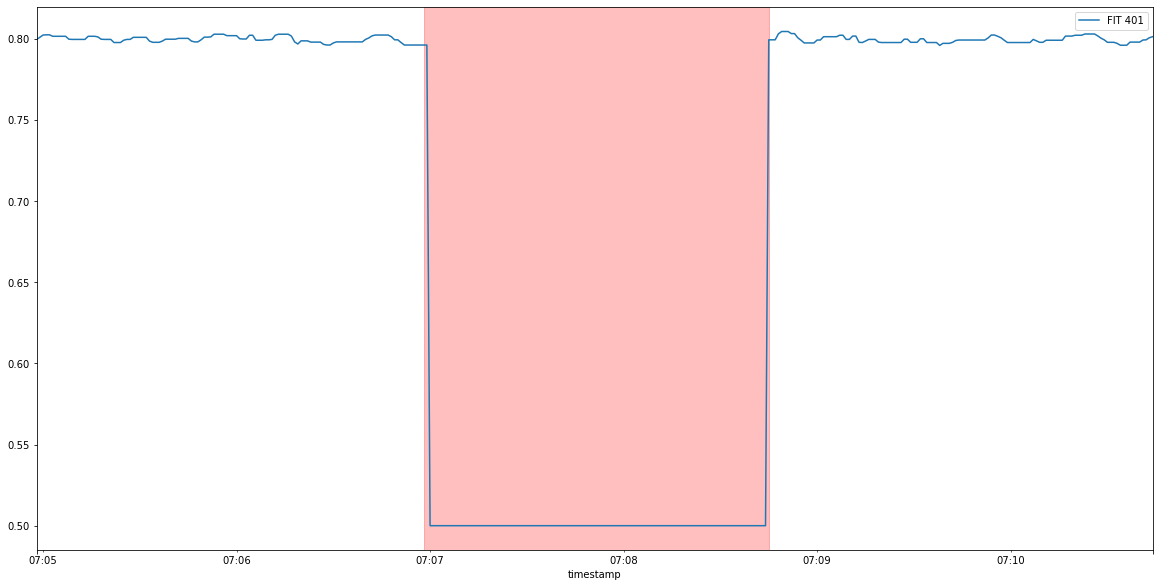

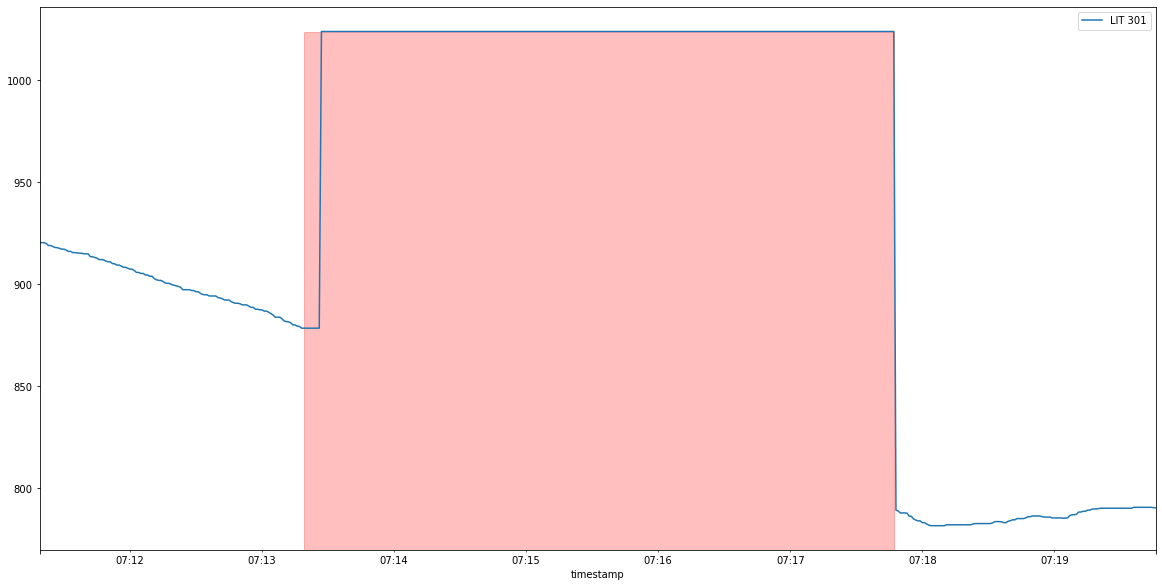

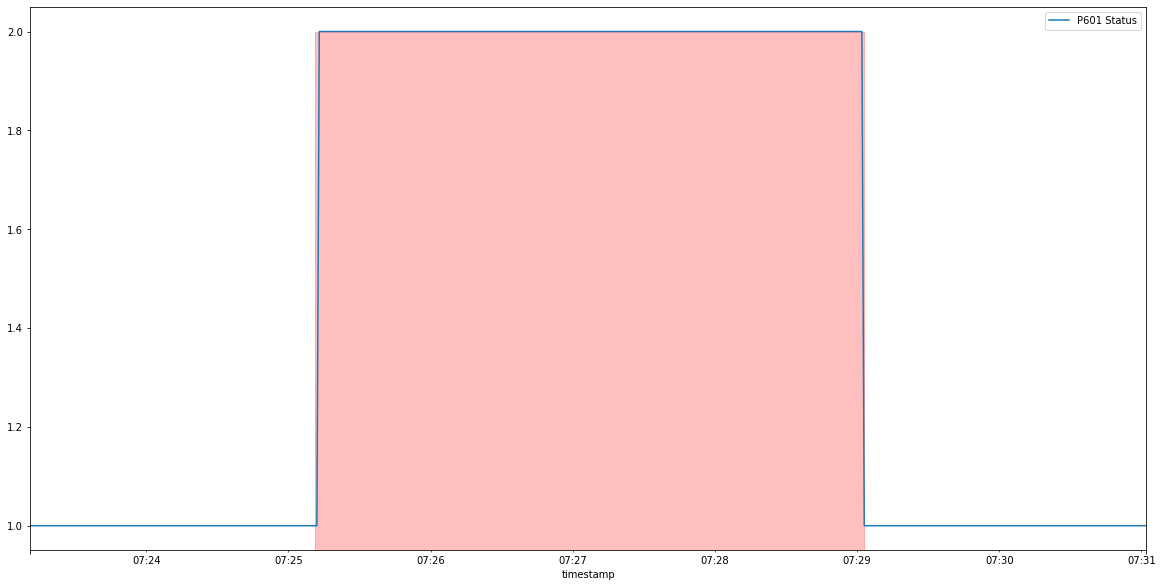

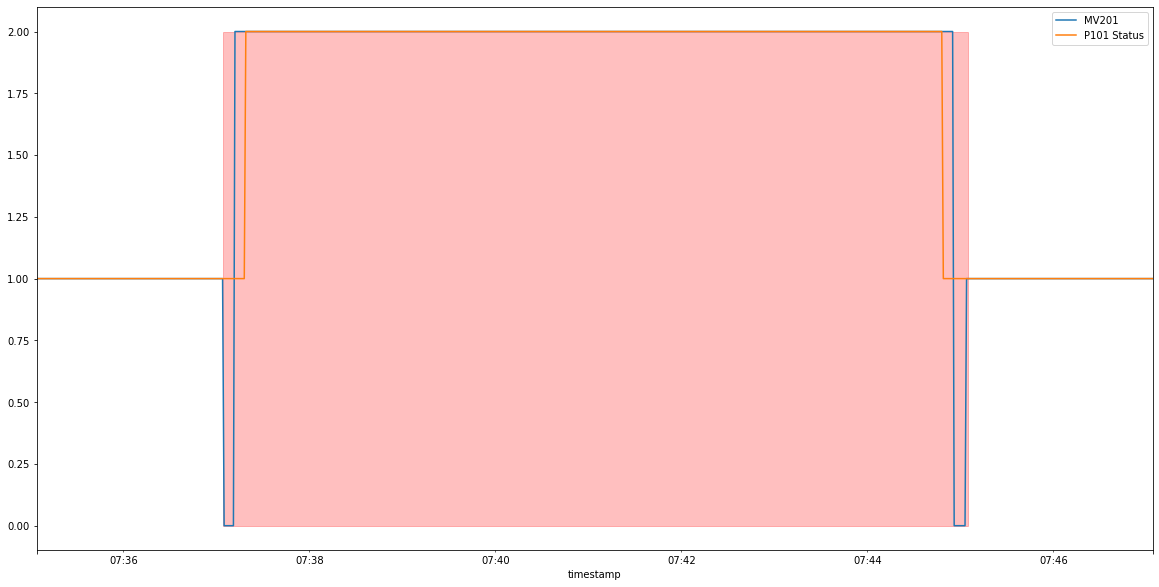

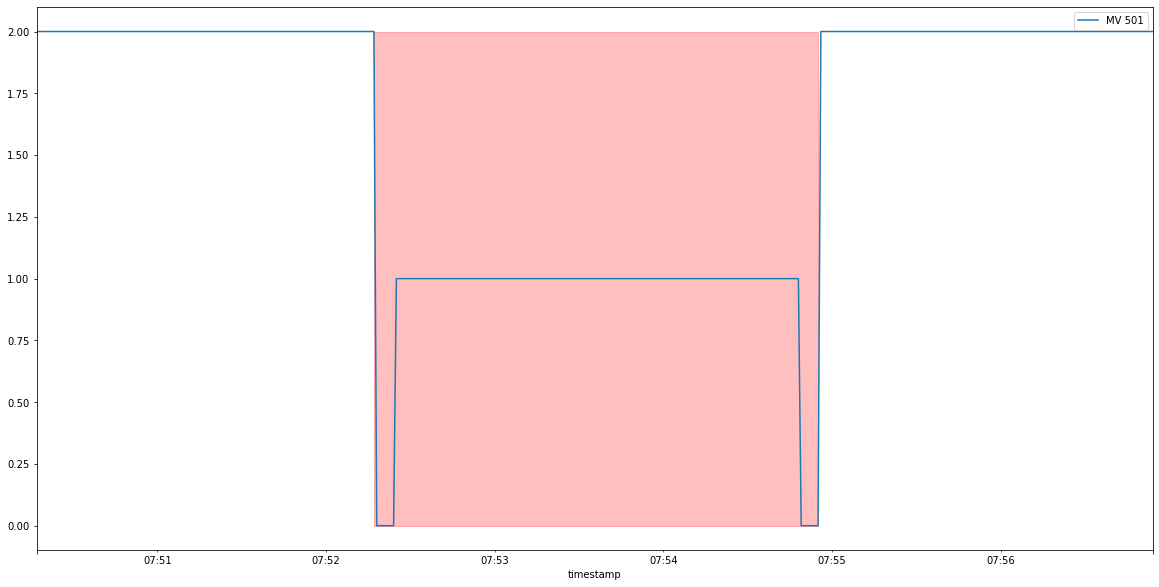

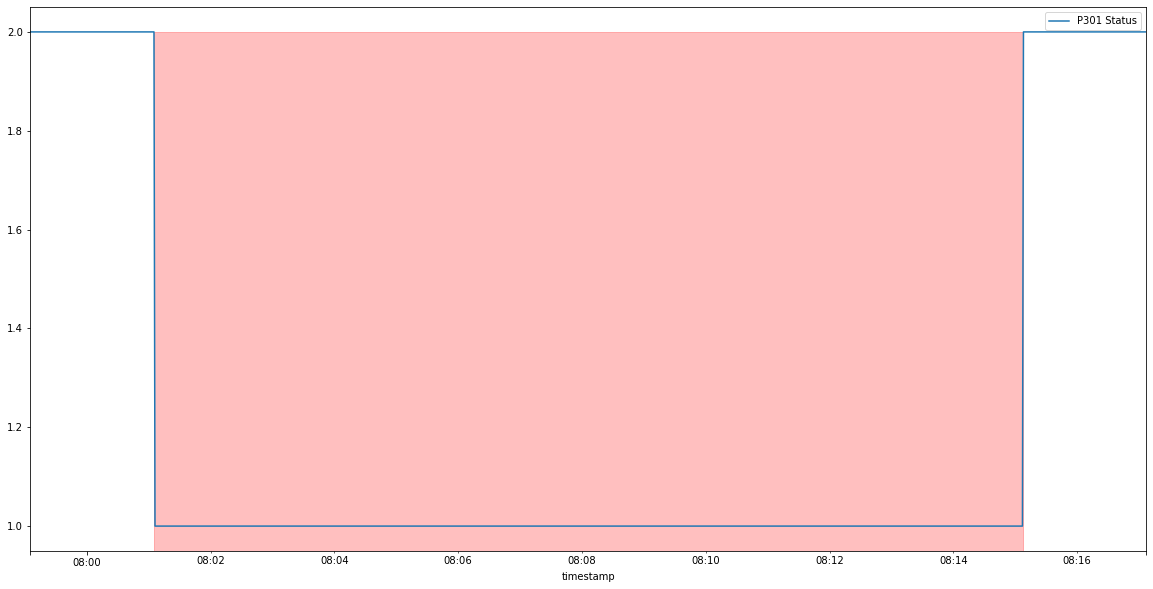

In [21]:
enlarge_x = 120
for i in range(6):
    a = list(anomalies.keys())[i]
    a = anomalies[a]
    targets = a["targets"]
    begin = a["begin"] - pd.Timedelta(enlarge_x, unit="s")
    end = a["end"] + pd.Timedelta(enlarge_x, unit="s")

    df_tmp = df.set_index("timestamp")
    df_tmp = df_tmp.loc[begin:end, targets + ["is_anomaly"]]
    df_tmp.iloc[:, :-1].plot()
    s = df_tmp["is_anomaly"].diff()
    for begin, end in zip(s[s == -1].index, s[s == 1].index):
        plt.gca().add_patch(matplotlib.patches.Rectangle((begin, 0), end - begin, df_tmp.max().max(), color="red", alpha=0.25))
    plt.show()

### A6

In [22]:
df = pd.read_excel(
    source_folder / "SWaT.A6_Dec 2019" / "csv" / "Dec2019.xlsx",
    sheet_name=0,
    skiprows=9,
    header=0,
    index_col=None,
    parse_dates=[0]
)

# localize timestamp
s = df["t_stamp"]
s = s.map(lambda dt: dt.tz_localize(tz="Asia/Hong_Kong"))
df.insert(0, "timestamp", s)
df.drop(columns=["t_stamp"], inplace=True)

df = df.replace("Inactive", 0)
df = df.replace("Active", 1)

df

,timestamp,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,...,FIT601.Pv,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
0,2019-12-06 10:05:00+08:00,3.0,658.661255,0.0,1.0,2.0,1.0,2.0,2.313523,35.215330,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
1,2019-12-06 10:05:01+08:00,3.0,659.171600,0.0,1.0,2.0,1.0,2.0,2.311857,35.215330,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
2,2019-12-06 10:05:02+08:00,3.0,659.681800,0.0,1.0,2.0,1.0,2.0,2.311601,35.215330,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
3,2019-12-06 10:05:03+08:00,3.0,660.349100,0.0,1.0,2.0,1.0,2.0,2.310448,35.215330,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
4,2019-12-06 10:05:04+08:00,3.0,660.780945,0.0,1.0,2.0,1.0,2.0,2.310448,35.215330,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,2019-12-06 13:44:56+08:00,2.0,704.704800,0.0,1.0,2.0,1.0,2.0,2.332233,27.396822,...,0.000256,1.0,1.0,1.0,0,0,1,0,0,1
13197,2019-12-06 13:44:57+08:00,2.0,703.801941,0.0,1.0,2.0,1.0,2.0,2.333643,27.396822,...,0.000256,1.0,1.0,1.0,0,0,1,0,0,1
13198,2019-12-06 13:44:58+08:00,2.0,703.016900,0.0,1.0,2.0,1.0,2.0,2.333643,27.396822,...,0.000256,1.0,1.0,1.0,0,0,1,0,0,1
13199,2019-12-06 13:44:59+08:00,2.0,701.996338,0.0,1.0,2.0,1.0,2.0,2.333643,27.396822,...,0.000256,1.0,1.0,1.0,0,0,1,0,0,1


In [23]:
anomalies = {
# ignore those attacks, because we could not find any evidence in the sensor data
#    "Infection": {
#        "description": "Infiltrate SCADA WS via USB",
#        "begin": "10:20",
#        "end": "10:30"
#    },
#    "Attack1": {
#        "description": "Exfiltrate data cycle 1",
#        "begin": "10:30",
#        "end": "10:35"
#    },
#    "Attack2": {
#        "description": "Exfiltrate data cycle 2",
#        "begin": "10:45",
#        "end": "10:50"
#    },
#    "Attack3": {
#        "description": "Exfiltrate data cycle 3",
#        "begin": "11:00",
#        "end": "11:05"
#    },
#    "Attack4": {
#        "description": "Exfiltrate data cycle 4",
#        "begin": "11:15",
#        "end": "11:20"
#    },
    "C2Com&Attack5": {
        "description": "Infiltrate SCADA WS with second payload from C2, and disrupt sensors cycle 1",
        "begin": "12:30",
        "end": "12:33"
    },
    "Attack6": {
        "description": "Disrupt sensors cycle 2",
        "begin": "12:43",
        "end": "12:46"
    },
    "Attack7": {
        "description": "Disrupt sensors cycle 3",
        "begin": "12:56",
        "end": "12:59"
    },
    "Attack8": {
        "description": "Disrupt sensors cycle 4",
        "begin": "13:09",
        "end": "13:12"
    },
    "Attack9": {
        "description": "Disrupt sensors cycle 5",
        "begin": "13:22",
        "end": "13:25"
    }
}

date = "2019-12-06"
tz = "Asia/Hong_Kong"

for a in anomalies:
    for dt_key in ["begin", "end"]:
        # convert times to datetimes
        dt = pd.to_datetime(f"{date} {anomalies[a][dt_key]}:00").tz_localize(tz=tz)
        anomalies[a][dt_key] = dt

In [24]:
df = df.set_index("timestamp")

df["is_anomaly"] = 0

for a in anomalies:
    begin = anomalies[a]["begin"]
    end = anomalies[a]["end"]
    df.loc[begin:end, "is_anomaly"] = 1
df = df.reset_index()
df

,timestamp,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,...,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm,is_anomaly
0,2019-12-06 10:05:00+08:00,3.0,658.661255,0.0,1.0,2.0,1.0,2.0,2.313523,35.215330,...,2.0,1.0,1.0,0,0,1,0,0,1,0
1,2019-12-06 10:05:01+08:00,3.0,659.171600,0.0,1.0,2.0,1.0,2.0,2.311857,35.215330,...,2.0,1.0,1.0,0,0,1,0,0,1,0
2,2019-12-06 10:05:02+08:00,3.0,659.681800,0.0,1.0,2.0,1.0,2.0,2.311601,35.215330,...,2.0,1.0,1.0,0,0,1,0,0,1,0
3,2019-12-06 10:05:03+08:00,3.0,660.349100,0.0,1.0,2.0,1.0,2.0,2.310448,35.215330,...,2.0,1.0,1.0,0,0,1,0,0,1,0
4,2019-12-06 10:05:04+08:00,3.0,660.780945,0.0,1.0,2.0,1.0,2.0,2.310448,35.215330,...,2.0,1.0,1.0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13196,2019-12-06 13:44:56+08:00,2.0,704.704800,0.0,1.0,2.0,1.0,2.0,2.332233,27.396822,...,1.0,1.0,1.0,0,0,1,0,0,1,0
13197,2019-12-06 13:44:57+08:00,2.0,703.801941,0.0,1.0,2.0,1.0,2.0,2.333643,27.396822,...,1.0,1.0,1.0,0,0,1,0,0,1,0
13198,2019-12-06 13:44:58+08:00,2.0,703.016900,0.0,1.0,2.0,1.0,2.0,2.333643,27.396822,...,1.0,1.0,1.0,0,0,1,0,0,1,0
13199,2019-12-06 13:44:59+08:00,2.0,701.996338,0.0,1.0,2.0,1.0,2.0,2.333643,27.396822,...,1.0,1.0,1.0,0,0,1,0,0,1,0


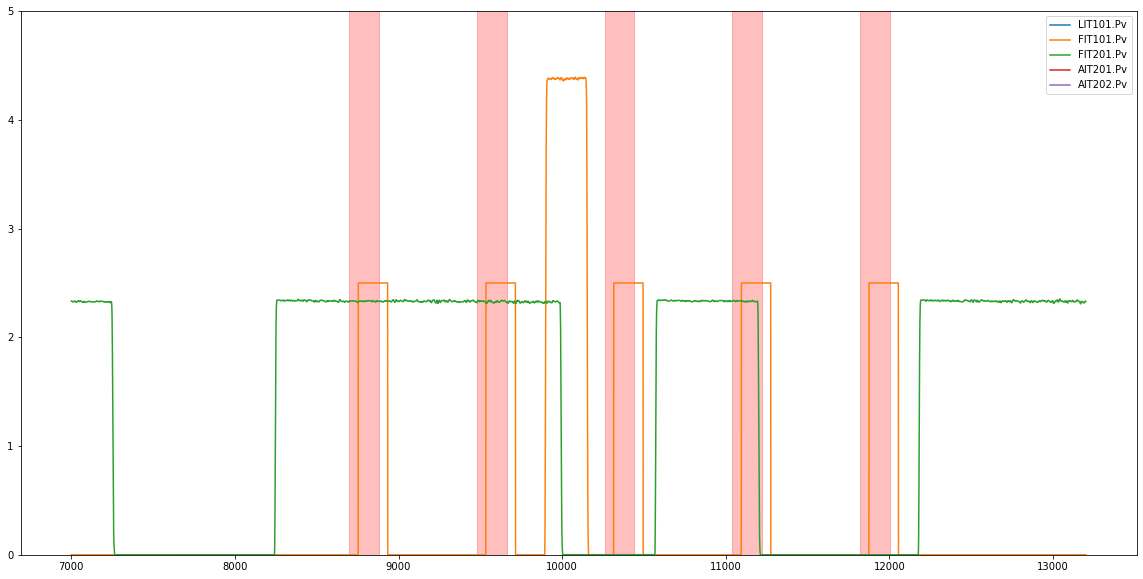

In [25]:
from sklearn.preprocessing import MinMaxScaler
columns = [c for c in df.columns if c.endswith("Pv")][:5]
df_tmp = df.loc[7000:, columns].copy()
plt.Figure()
df_tmp.plot()
s = df["is_anomaly"].diff()
for begin, end in zip(s[s == -1].index, s[s == 1].index):
    plt.gca().add_patch(matplotlib.patches.Rectangle((begin, 0), end - begin, df_tmp.max().max(), color="red", alpha=0.25))
plt.gca().set_ylim(0, 5)
plt.show()